In [47]:
%matplotlib inline
from dpm.visualize import plot_models, plot_stats
from dpm.distributions import Distribution
from dpm.train import Statistics, update_stats

import torch 
from torch.distributions import MultivariateNormal, Categorical
from torch.nn import Module, Parameter, ModuleList
from torch import optim
import numpy as np
import matplotlib.pyplot as plt

# Normal Distribution Code

In [48]:
class Normal(Distribution):

    def __init__(self, loc=0., scale=1., learnable=True, diag=False):
        super().__init__()
        if not isinstance(loc, torch.Tensor):
            loc = torch.tensor(loc).view(-1)
        self.n_dims = len(loc)
        if not isinstance(scale, torch.Tensor):
            scale = torch.tensor(scale).view(-1)
        if diag:
            scale = torch.diag(scale)
        self.loc = loc
        self.cholesky_decomp = scale.view(self.n_dims, self.n_dims).cholesky()
        if learnable:
            self.loc = Parameter(self.loc)
            self.cholesky_decomp = Parameter(self.cholesky_decomp)

    def log_prob(self, value):
        model = MultivariateNormal(self.loc, self.scale)
        return model.log_prob(value)

    def sample(self, batch_size):
        model = MultivariateNormal(self.loc, self.scale)
        return model.rsample((batch_size,))

    @property
    def scale(self):
        return torch.mm(self.cholesky_decomp, self.cholesky_decomp.t())

    def get_parameters(self):
        return {'loc':self.loc.item(), 'scale':self.scale.item()}

# Mixture Model Code

In [49]:
class MixtureModel(Distribution):
    def __init__(self, models, probs):
        super().__init__()
        self.n_dims = models[0].n_dims
        self.categorical = Categorical(probs=torch.tensor(probs))
        self.models = ModuleList(models)

    def log_prob(self, value):
        log_probs = torch.stack([sub_model.log_prob(value)
                                 for sub_model in self.models])
        cat_log_probs = self.categorical.probs.view(-1, 1).log()
        return torch.logsumexp(log_probs + cat_log_probs, dim=0)

    def sample(self, batch_size):
        indices = self.categorical.sample((batch_size,))
        samples = torch.stack([sub_model.sample(batch_size)
                               for sub_model in self.models])
        return samples[indices, np.arange(batch_size)]


# Divergence Code

In [50]:
def forward_kl(p_model, q_model, batch_size=64):
    p_samples = p_model.sample(batch_size)
    return (p_model.log_prob(p_samples) - q_model.log_prob(p_samples)).mean()


def reverse_kl(p_model, q_model, batch_size=64):
    q_samples = q_model.sample(batch_size)
    return -(p_model.log_prob(q_samples) - q_model.log_prob(q_samples)).mean()


def js_divergence(p_model, q_model, batch_size=64):
    M = MixtureModel([p_model, q_model], [0.5, 0.5])
    return 0.5 * (forward_kl(p_model, M, batch_size)
                  + forward_kl(q_model, M, batch_size))



# Train Code

In [51]:
def train(p_model, q_model, criterion, epochs=1000, batch_size=64,
          lr=0.01, optimizer='Adam', track_parameters=True, log_interval=None,
          stats=None, clip_gradients=None):

    optimizer = getattr(optim, optimizer)(q_model.parameters(), lr=lr)

    if stats is None:
        stats = Statistics()

    for epoch in range(epochs):
        optimizer.zero_grad()

        loss = criterion(p_model, q_model, batch_size)
        loss.backward()

        optimizer.step()

        stats.update({'loss':loss.item()})
        if track_parameters:
            update_stats(stats, q_model)

        if log_interval is not None and epoch % log_interval == 0:
            print(f"[Epoch {epoch}/{epochs}]\tLoss {loss.item():.2f}")

    return stats


# Running the Code

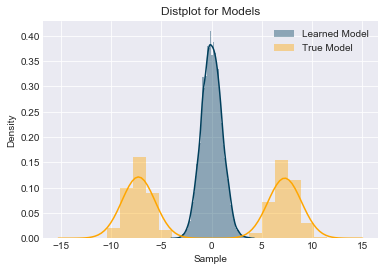

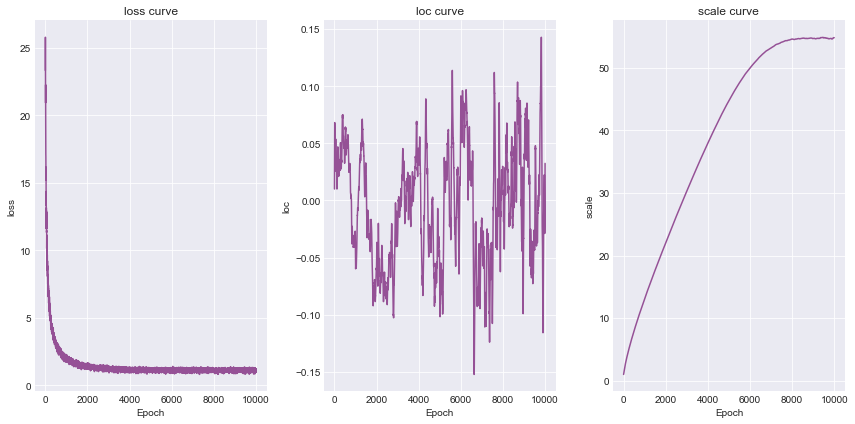

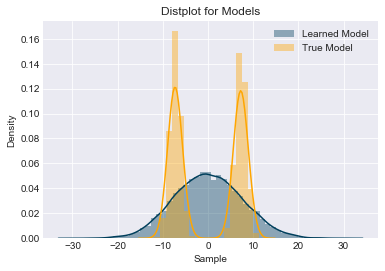

In [59]:
p_model = MixtureModel([Normal(-7.3, 1.4), Normal(7.3, 1.4)],
                       [0.5, 0.5])
q_model = Normal()

plot_models(p_model, q_model); plt.show()
stats = train(p_model, q_model, forward_kl, epochs=10000)
plot_stats(stats); plt.show()
plot_models(p_model, q_model); plt.show()

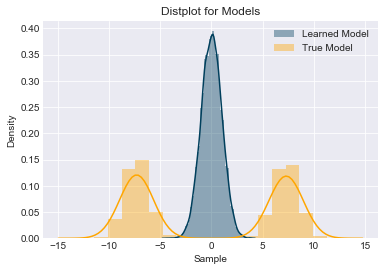

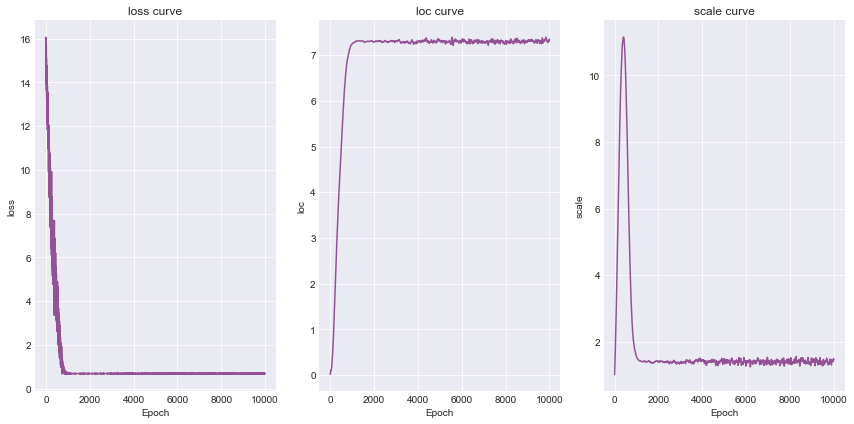

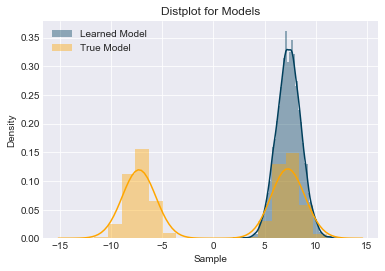

In [60]:
p_model = MixtureModel([Normal(-7.3, 1.4), Normal(7.3, 1.4)],
                       [0.5, 0.5])
q_model = Normal()

plot_models(p_model, q_model); plt.show()
stats = train(p_model, q_model, reverse_kl, epochs=10000)
plot_stats(stats); plt.show()
plot_models(p_model, q_model); plt.show()

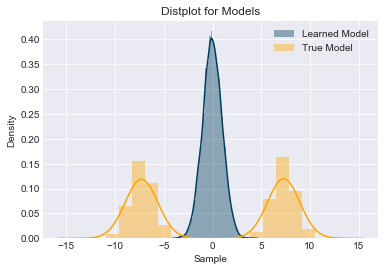

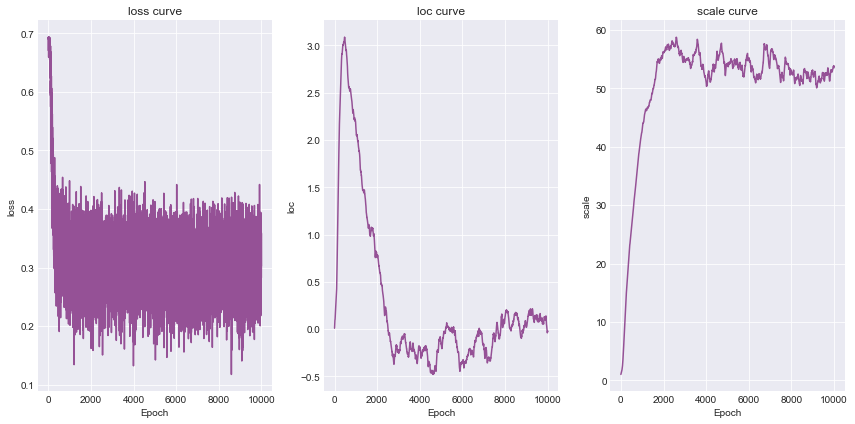

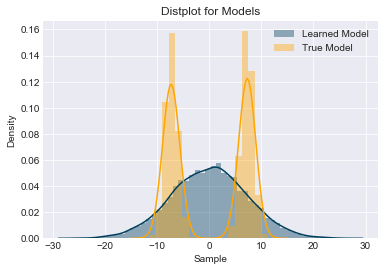

In [61]:
p_model = MixtureModel([Normal(-7.3, 1.4), Normal(7.3, 1.4)],
                       [0.5, 0.5])
q_model = Normal()

plot_models(p_model, q_model); plt.show()
stats = train(p_model, q_model, js_divergence, epochs=10000)
plot_stats(stats); plt.show()
plot_models(p_model, q_model); plt.show()